We will be defining an SEIRD model using ModelingToolkit; each of S(usceptible), E(xposed), I(nfected), R(ecovered), D(ead) depend on time (`t`). The model is based on https://www.mdpi.com/1660-4601/18/17/9027

In [1]:
@time using ModelingToolkit, OrdinaryDiffEq, Plots, EasyModelAnalysis

 24.714638 seconds (42.34 M allocations: 2.730 GiB, 5.76% gc time, 13.11% compilation time: 45% of which was recompilation)


In [2]:
@variables t S(t) E(t) I(t) R(t) D(t)
Dt = Differential(t)

(::Differential) (generic function with 3 methods)

We define default parameters, that we can overwrite later when adjusting our model.
α is the fatality rate.
β is the expected number of people an infected person infects per day.
γ is the proportion of recovery per day.
δ is the incubation period.
ρ is the inverse of the average number of days for an infected person to die, if they do not recover.
[Paper](https://www.mdpi.com/1660-4601/18/17/9027), section 2.

In [3]:
@parameters ϵ k₁=5.0 t₀=50.0 βs=1.0 βc=0.4 βnc=0.5 α=6.4e-4 R₀=5.0 γ=1/11 δ=1/5 ρ=1/9  N = 5_600_000

12-element Vector{Num}:
   ϵ
  k₁
  t₀
  βs
  βc
 βnc
   α
  R₀
   γ
   δ
   ρ
   N

To model compliance to intervention, we use the following formula (equation 9 from the paper):

In [4]:
m(t) = βc + (βs - βc) / (1 + exp(k₁*(t-t₀)))
β = γ * R₀ * m(t)

R₀*γ*(βc + (βs - βc) / (1 + exp(k₁*(t - t₀))))

Singapore has a population of 5.6 million.

In [5]:
const N_singapore = 5_600_000

5600000

Specifying the equations of our model:

In [6]:
exposure = β*S*I/N
infection = δ*E
recover = (1-α)*γ*I
death = α*ρ*I
	
eqs = [
    Dt(S) ~ -exposure,
    Dt(E) ~ exposure - infection,
    Dt(I) ~ infection - recover - death,
    Dt(R) ~ recover,
    Dt(D) ~ death
];

In [7]:
tspan = (0.0, 365)
@time @named seir_model = ODESystem(eqs, t, [S, E, I, R, D], [k₁, R₀, α, βc, βs, t₀, N, γ, δ, ρ]; tspan)

  4.287262 seconds (8.66 M allocations: 511.304 MiB, 7.19% gc time, 99.65% compilation time)


Model seir_model with 5 equations
States (5):
  S(t)
  E(t)
  I(t)
  R(t)
  D(t)
Parameters (10):
  k₁ [defaults to 5.0]
  R₀ [defaults to 5.0]
  α [defaults to 0.00064]
  βc [defaults to 0.4]
  βs [defaults to 1.0]
  t₀ [defaults to 50.0]
  N [defaults to 5600000]
  γ [defaults to 0.0909091]
  δ [defaults to 0.2]
  ρ [defaults to 0.111111]

We specify our initial values and tspan (1 year):

In [8]:
tspan=(0.0, 365.0)
u0 = Float64[N_singapore-1,1,0,0,0];

Specify models for each of the 4 t_0 conditions from figure 3 of the paper:

In [9]:
seir_prob_delay_0 = ODEProblem(seir_model, u0, (0.0, 365.0), [t₀ => 0.0])
seir_prob_delay_50 = ODEProblem(seir_model, u0, (0.0, 365.0), [t₀ => 50.0])
seir_prob_delay_100 = ODEProblem(seir_model, u0, (0.0, 365.0), [t₀ => 100.0])
seir_prob_delay_1000 = ODEProblem(seir_model, u0, (0.0, 365.0), [t₀ => 1e3])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 365.0)
u0: 5-element Vector{Float64}:
 5.599999e6
 1.0
 0.0
 0.0
 0.0

  2.566140 seconds (4.00 M allocations: 254.212 MiB, 6.25% gc time, 100.00% compilation time)


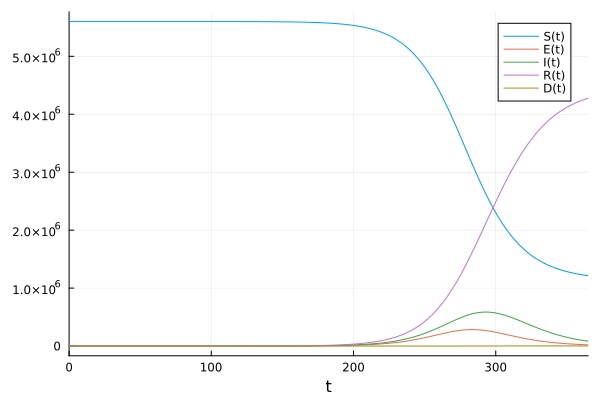

In [10]:
plot(@time solve(seir_prob_delay_0, Vern9()))

In [11]:
imax_0, imaxval_0 = get_max_t(seir_prob_delay_0, I); imax_0, imaxval_0/N

(293.0508916431, 586651.2465149867 / N)

  0.000081 seconds (605 allocations: 62.516 KiB)


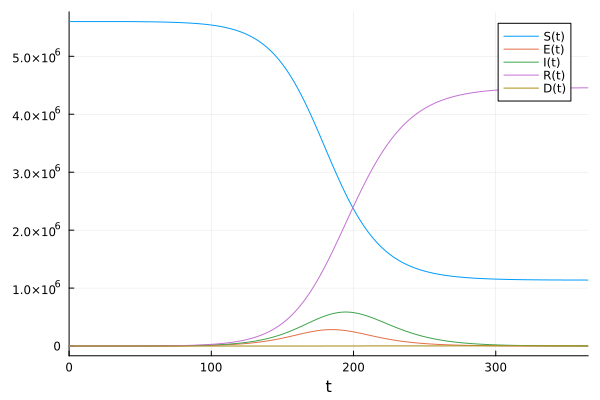

In [12]:
plot(@time solve(seir_prob_delay_50, Vern9()))

In [13]:
imax_50, imaxval_50 = get_max_t(seir_prob_delay_50, I); imax_50, imaxval_50/N

(195.2125850586356, 587171.0740003757 / N)

  0.000080 seconds (581 allocations: 60.203 KiB)


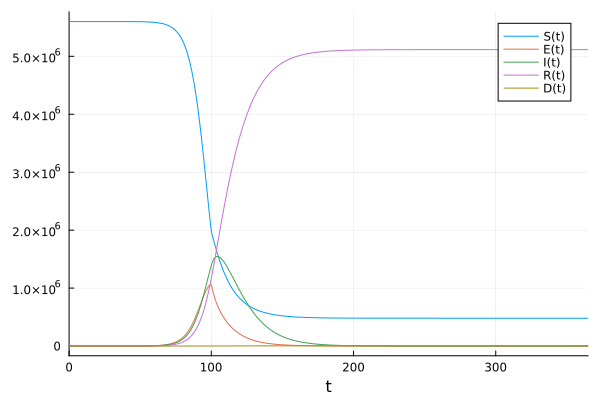

In [14]:
plot(@time solve(seir_prob_delay_100, Vern9()))

In [15]:
imax_100, imaxval_100 = get_max_t(seir_prob_delay_100, I); imax_100, imaxval_100/N

(104.35005866854455, 1.5620476114855274e6 / N)

  0.000088 seconds (557 allocations: 57.891 KiB)


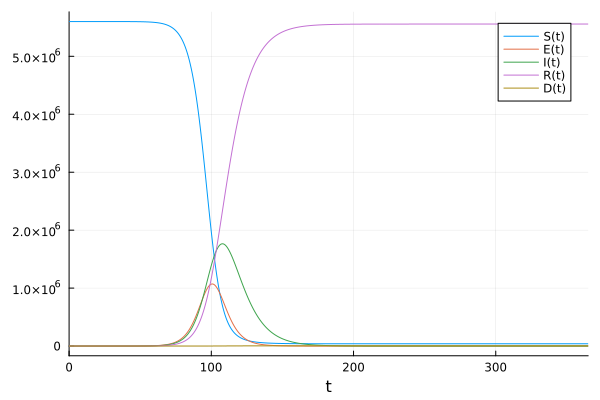

In [16]:
plot(@time solve(seir_prob_delay_1000, Vern9()))

In [17]:
imax_1000, imaxval_1000 = get_max_t(seir_prob_delay_1000, I); imax_1000, imaxval_1000/N

(107.84026548834662, 1.7646507935068863e6 / N)

Great, now let's try and calibrate on some real data and extrapolate.

In [18]:
@time using CSV, DataFrames, Dates, Optimization, OptimizationPolyalgorithms, Logging

  3.116193 seconds (3.16 M allocations: 179.063 MiB, 4.36% gc time, 0.69% compilation time: 100% of which was recompilation)


We'll pick Virginia, because they have a decent population and were slow to take serious action:

In [19]:
state = "Virginia"
const N_virginia = 8.642e6;

# cases give new cases
cumulative_cases = @time CSV.read("../covid19-forecast-hub/data-truth/truth-Cumulative Cases.csv", DataFrame)
cumulative_deaths = @time CSV.read("../covid19-forecast-hub/data-truth/truth-Cumulative Deaths.csv", DataFrame)

virginia_cumulative_cases = cumulative_cases[cumulative_cases.location_name .== state, :];
virginia_cumulative_deaths = cumulative_deaths[cumulative_deaths.location_name .== state, :];


# we use the cumulative cases for the loss function
# masking became mandatory May 29th, 2020
mandatory = Date(2020, 5, 29)
virginia_data = virginia_cumulative_cases[virginia_cumulative_cases.date .< mandatory, :];
virginia_deaths = virginia_cumulative_deaths[virginia_cumulative_deaths.date .< mandatory, :];

# range from March to mask start
daterange = range(mandatory, stop = Date(2020,2,28), step = Day(-7)) |> reverse

data_subset = diff(virginia_data.value[virginia_data.date .∈ Ref(daterange)]) .* 5/7;
deaths_subset = Float64.(virginia_deaths.value[virginia_deaths.date .∈ Ref(daterange)][2:end]);

  5.623208 seconds (5.13 M allocations: 571.122 MiB, 1.21% gc time, 441.91% compilation time: 5% of which was recompilation)
  1.595696 seconds (4.47 M allocations: 393.071 MiB, 93.12% compilation time)


In [20]:
tspan_fit = (0.0, 7.0length(daterange));
@time @named seir_fit_model = ODESystem(eqs, t, [S, E, I, R, D], [k₁, R₀, α, βc, βs, t₀, N, γ, δ, ρ]; tspan=tspan_fit)

  0.481251 seconds (916.15 k allocations: 48.072 MiB, 99.29% compilation time)


Model seir_fit_model with 5 equations
States (5):
  S(t)
  E(t)
  I(t)
  R(t)
  D(t)
Parameters (10):
  k₁ [defaults to 5.0]
  R₀ [defaults to 5.0]
  α [defaults to 0.00064]
  βc [defaults to 0.4]
  βs [defaults to 1.0]
  t₀ [defaults to 50.0]
  N [defaults to 5600000]
  γ [defaults to 0.0909091]
  δ [defaults to 0.2]
  ρ [defaults to 0.111111]

Lets do a test solve:

  1.081293 seconds (2.44 M allocations: 126.267 MiB, 6.88% gc time, 99.80% compilation time: 88% of which was recompilation)


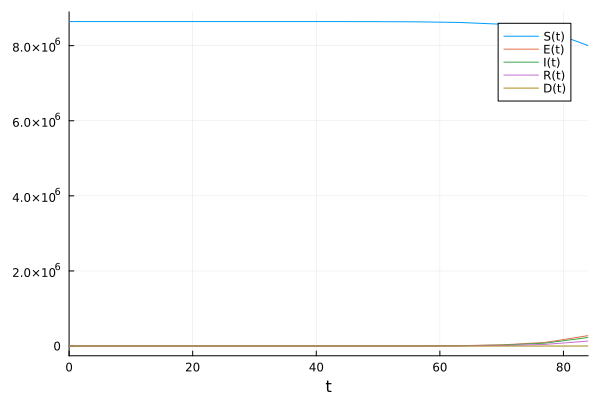

In [21]:
u0 = [N_virginia-1,1,0,0,0];
t0 = Float64((mandatory - first(daterange)).value);
seir_prob = @time ODEProblem(seir_model, u0, tspan, [t₀ => t0, N => N_virginia])


plot(solve(seir_prob, AutoVern9(Rodas5P()), saveat = range(0.0,step=7,length=13)))

This covers the time range from the start, until masking became mandated. Our time range is clearly missing most of the interesting features here.

Now, let's define a loss function for our initial fit.
To ease the solver, we transform our parameters to an unconstrained space, and do our solving in this space.

In [22]:
logit(x) = log(x) - log1p(-x)
invlogit(x) = 1 / (1 + exp(-x))
    
function untransform(newp)
  logk₁, logR₀, logitα = newp
  T = eltype(newp)
  t0 = T(91.0)
  [k₁=>exp(logk₁), R₀=>exp(logR₀), α=>invlogit(logitα), t₀=>t0]
end

loss = let infected = data_subset, deaths = deaths_subset, I=I,D=D, prob=seir_prob
  newp -> begin
    # 39 days until first suggested (non-mandatory) mask advisory
    p = untransform(newp)
    newprob = remake(prob; p)
    _N = all(isfinite, newp) ? length(deaths) : 0
    sol = with_logger(NullLogger()) do
      solve(newprob, AutoVern9(Rodas5P()), saveat = range(0.0,step=7,length=_N))
    end
    solI = sol[I]
    solD = sol[D]
    l = zero(Base.promote_eltype(solI,solD))
    sol.retcode == ReturnCode.Success || return oftype(l,Inf), sol
    @inbounds @fastmath for i = 1:_N
      l += abs2((solI[i] - infected[i])/(infected[i] + 5))
      l += abs2((solD[i] - deaths[i])/(deaths[i] + 5))
    end
    return l, sol
  end
end

pguess = [log(5.0), log(5.0), logit(6.4e-4)]
loss(pguess)[1]

298.3149394978036

In [23]:
optf = Optimization.OptimizationFunction((x, p) -> loss(x), Optimization.AutoForwardDiff())
optprob = Optimization.OptimizationProblem(optf, pguess)

result_ode = @time Optimization.solve(optprob, PolyOpt(); maxiters = 20_000)
loss(result_ode)[1]

 27.608053 seconds (111.12 M allocations: 7.484 GiB, 5.10% gc time, 61.26% compilation time: <1% of which was recompilation)


298.3149394978036

That didn't improve anything. Let's try multistart.

In [28]:
initial_loss = loss(result_ode)[1]
using ThreadsX
multistartresults = @time let optf=optf
    ThreadsX.map(1:100) do _
        local new_result = Optimization.solve(Optimization.OptimizationProblem(optf, randn(3)), PolyOpt(); maxiters = 20_000)
        loss(new_result)[1], new_result
    end
end
best_sim_loss, bestind = findmin(first, multistartresults)
best_params =  if best_sim_loss < initial_loss
    multistartresults[bestind][2]
else
    result_ode
end
best_sim_loss

 20.996798 seconds (430.84 M allocations: 37.018 GiB, 15.30% gc time, 0.83% compilation time)
 22.033878 seconds (449.83 M allocations: 38.563 GiB, 15.42% gc time, 0.79% compilation time)
 22.153244 seconds (451.89 M allocations: 38.722 GiB, 15.34% gc time, 0.63% compilation time)
 21.370168 seconds (437.00 M allocations: 37.529 GiB, 15.53% gc time, 0.82% compilation time)
 33.018019 seconds (638.24 M allocations: 53.160 GiB, 14.86% gc time, 1.73% compilation time)
 28.016016 seconds (554.06 M allocations: 46.625 GiB, 15.14% gc time, 2.04% compilation time)
 22.174682 seconds (452.26 M allocations: 38.750 GiB, 15.32% gc time, 1.76% compilation time)
 15.819380 seconds (271.06 M allocations: 21.194 GiB, 13.75% gc time, 0.04% compilation time)
 23.092945 seconds (409.63 M allocations: 32.615 GiB, 13.85% gc time, 4.09% compilation time)
 21.283135 seconds (434.90 M allocations: 37.358 GiB, 15.60% gc time, 0.82% compilation time)
 24.789481 seconds (441.01 M allocations: 35.257 GiB, 14.16%

11.9795128695626

  0.001490 seconds (7.70 k allocations: 503.805 KiB)


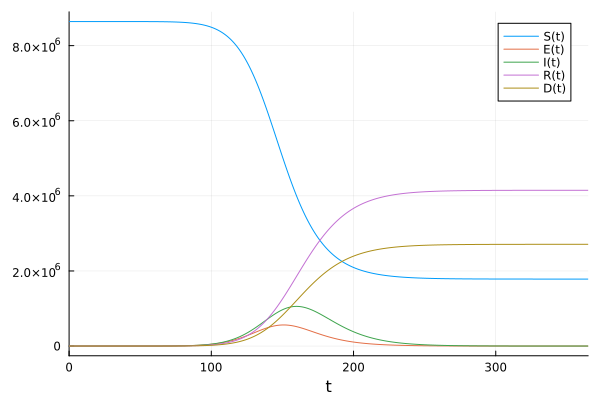

In [29]:
proj_range = 0.0:365.0;
params0 = untransform(best_params);
seir_proj = @time ODEProblem(seir_model, u0, (0.0, 365.0), [t₀ => t0, N => N_virginia])

proj_default = remake(seir_proj; p=params0, tspan = (0.0, 365.0))
proj_compliance2 = remake(seir_proj; p=vcat(params0,[βc=>0.2, βs=>1.0]), tspan = (0.0, 365.0))
proj_compliance6 = remake(seir_proj; p=vcat(params0,[βc=>0.6, βs=>1.0]), tspan = (0.0, 365.0))

sol_default = solve(proj_default, AutoVern9(Rodas5P()), saveat = proj_range)
sol_compliance2 = solve(proj_compliance2, Vern9(Rodas5P()), saveat = proj_range)
sol_compliance6 = solve(proj_compliance6, AutoVern9(Rodas5P()), saveat = proj_range)

plot(sol_default)

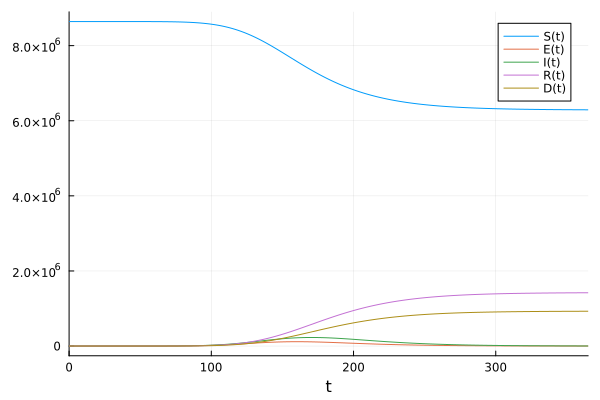

In [30]:
plot(sol_compliance2)

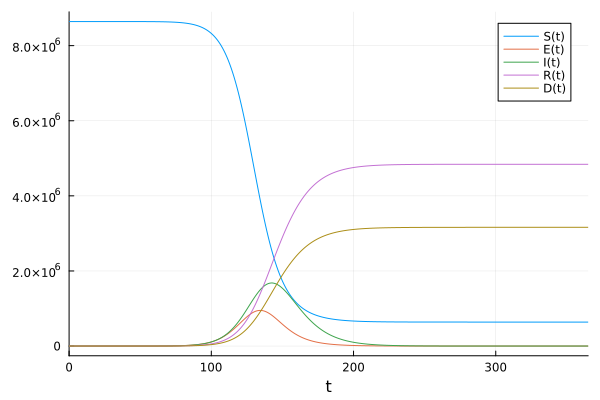

In [32]:
plot(sol_compliance6)